# Example: Find optimal seismic arrays using pre-computed NRMS

Set the backend of matplotlib to the 'inline' backend (specific for Jupyter notebooks) so that result of all plotting commands is displayed inline directly below the code cell that produces it.

In [1]:
 %matplotlib inline

#### Import the standard and third party Python libraries.

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 0

sys.path.insert(0, os.sep.join(['..', '..', 'source']))
from openiam import SystemModel
sys.path.insert(0, os.sep.join(['..', '..', 'ramp']))
from ramp.data_container import default_bin_file_reader, process_time_points, get_indices
from ramp.monitoring_technology import MonitoringTechnology
from ramp.seismic_data_container import SeismicDataContainer
from ramp.seismic_configuration import SeismicSurveyConfiguration
from ramp.seismic_configuration import five_n_receivers_array_creator
from ramp.seismic_monitoring import SeismicMonitoring
from ramp.seismic_evaluation import SeismicEvaluation
from ramp.ttd_det_optimization import *

#### Setup arguments of system model.

In [3]:
# Define keyword arguments of the system model
final_year = 200
num_intervals = (final_year-10)//10
time_array = 365.25*np.linspace(10.0, final_year, num=num_intervals+1)
sm_model_kwargs = {'time_array': time_array}   # time is given in days

#### Setup arguments of seismic data container.

In [4]:
# Observation name
obs_name = 'seismic'

# Path to the data files
data_directory = os.path.join('..', '..', 'data', 'user', 'seismic')
output_directory = os.path.join('..', '..', 'examples', 'user', 'output',
                                'ramp_sys_seismic_monitoring_multiple_scenarios')
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

# Data reader to be used to read data files
data_reader = default_bin_file_reader
# Keyword arguments for reader specifying expected data shape and reformatting needed
data_reader_kwargs = {'data_shape': (1251, 101, 9),
                      'move_axis_destination': [-1, -2, -3]}

# Time points at which data is available, in years
time_points = np.linspace(10.0, final_year, num=num_intervals+1)
num_time_points = len(time_points)

# Select scenarios to link to the data container
scenarios = [12, 109, 622, 141, 318, 881, 986, 22, 76, 269]
num_scenarios = len(scenarios)

# Data family
family = 'seismic'

# Setup dictionary needed for data container setup
data_setup = {}
for ind in scenarios:
    data_setup[ind] = {'folder': os.path.join('data_sim{:04}'.format(ind), 'data')}
    for t_ind in range(1, num_time_points+1):
        data_setup[ind]['t{}'.format(t_ind)] = 'data_sim{:04}_t{}.bin'.format(ind, t_ind*10)

# baseline is True if data is supposed to have baseline data
baseline = True

#### Print summary of available data.

In [5]:
print('Type of data:', family)
print('Number of available scenarios:', num_scenarios)
print('Scenarios to be analyzed:', scenarios)
print('Years at which data is analyzed:', time_points)
print('Expected data shape:', (9, 101, 1251), '= (n_s x n_r x n_t)')
print('n_s: number of sources')
print('n_r: number of receivers')
print('nt: number of time samples for each trace')

Type of data: seismic
Number of available scenarios: 10
Scenarios to be analyzed: [12, 109, 622, 141, 318, 881, 986, 22, 76, 269]
Years at which data is analyzed: [ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140.
 150. 160. 170. 180. 190. 200.]
Expected data shape: (9, 101, 1251) = (n_s x n_r x n_t)
n_s: number of sources
n_r: number of receivers
nt: number of time samples for each trace


#### Setup arguments of seismic survey configuration for all available sources and receivers.

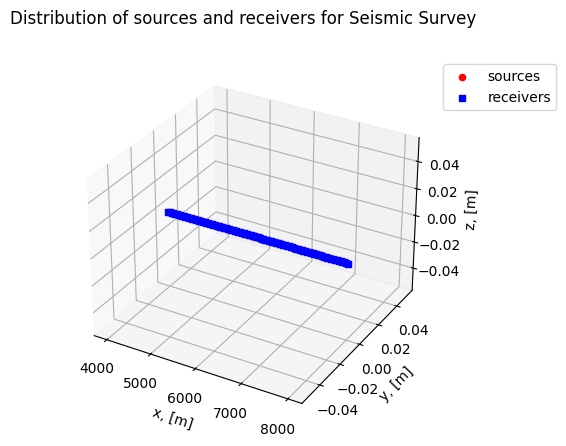

In [61]:
# Define coordinates of sources
num_sources = 9
sources = np.c_[4000 + np.array([240, 680, 1120, 1600, 2040, 2480, 2920, 3400, 3840]),
                np.zeros(num_sources),
                np.zeros(num_sources)]

# Define coordinates of receivers
num_receivers = 101
receivers = np.c_[4000 + np.linspace(0, 4000, num=num_receivers),
                  np.zeros(num_receivers),
                  np.zeros(num_receivers)]

# Create survey with defined coordinates
survey_config = SeismicSurveyConfiguration(sources, receivers, name='Seismic Survey')
survey_config.plot_configuration()

#### Generate a set of (in this case 498) seismic arrays

In [7]:
num_arrays,produced_arrays = five_n_receivers_array_creator(sources, receivers)
num_arrays,len(produced_arrays)

(489, 489)

#### Load NRMS array from pre-computed npz file, define threshold

In [8]:
nrms = np.load('arrays_nrms_data_3rd_max_value_300_scenarios.npz')['data']
threshold = 50
nrmsBool = np.array(nrms>threshold,dtype='bool')

#### Compute the best possible time to detection and number of leaks detected, using current threshold. This is the best detection possible assuming no cost constraints, ie if we carry out 489 seismic surveys and repeat them for all 20 timesteps. The goal is to get close to that performance using only a few seismic surveys.

In [9]:
det_best = 0
ttd_best = []
for iScenario in range(nrms.shape[1]):
  if np.any(nrmsBool[:,iScenario,:]):
    det_best += 1
  if len(np.where(np.any(nrmsBool[:,iScenario,:],axis=0))[0])>0:
    ttd_best+=[ np.min(np.where(np.any(nrmsBool[:,iScenario,:],axis=0))[0]) ]

#### Compute every possible monitoring plans containing only one single seismic survey repeated at one timestep, and identify the subset of those monitoring plans composing the Pareto front

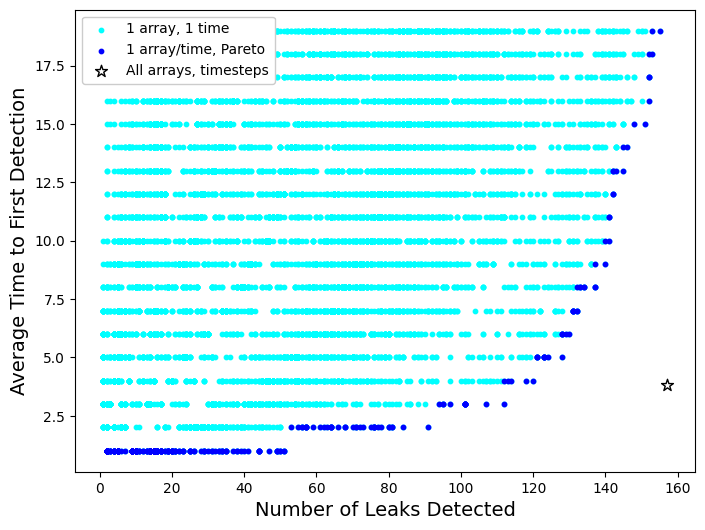

In [16]:
plans1 = single_array_timings(nrmsBool)
plans1up = find_unique_pareto(plans1)

x1 = np.array([plan[1] for plan in plans1])
y1 = np.array([plan[2] for plan in plans1])
r1 = pareto(x1,y1)

plt.figure(figsize=(8,6))
plt.scatter(x1,y1,s=10,c='cyan',label='1 array, 1 time')
plt.scatter(x1[r1==1],y1[r1==1],s=10,c='blue',label='1 array/time, Pareto')
plt.scatter(det_best,np.mean(ttd_best),s=80,marker='*',ec='black',fc='white',zorder=5,label='All arrays, timesteps')
xlim = plt.xlim()
ylim = plt.ylim()
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Number of Leaks Detected',fontsize=14)
plt.ylabel('Average Time to First Detection',fontsize=14)
plt.legend(loc='upper left', framealpha=1.0)
plt.show()

#### Take previous Pareto front monitoring plans, and consider every possible additional survey geometry and timestep that could be added. Repeat this process several times

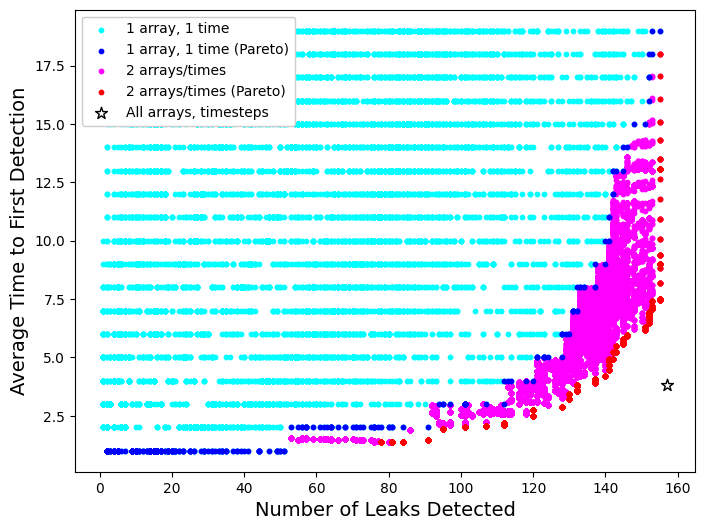

In [17]:
plans2 = additional_array_timings(plans1up,nrmsBool)
plans2up = find_unique_pareto(plans2)

x2 = np.array([plan[1] for plan in plans2])
y2 = np.array([plan[2] for plan in plans2])
r2 = pareto(x2,y2)

plt.figure(figsize=(8,6))
plt.scatter(x1,y1,s=10,c='cyan',label='1 array, 1 time')
plt.scatter(x1[r1==1],y1[r1==1],s=10,c='blue',zorder=4,label='1 array, 1 time (Pareto)')
plt.scatter(x2,y2,s=10,c='magenta',zorder=1,label='2 arrays/times')
plt.scatter(x2[r2==1],y2[r2==1],s=10,c='red',zorder=2,label='2 arrays/times (Pareto)')
plt.scatter(det_best,np.mean(ttd_best),s=80,marker='*',ec='black',fc='white',zorder=5,label='All arrays, timesteps')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Number of Leaks Detected',fontsize=14)
plt.ylabel('Average Time to First Detection',fontsize=14)
plt.legend(loc='upper left', framealpha=1.0)
plt.show()

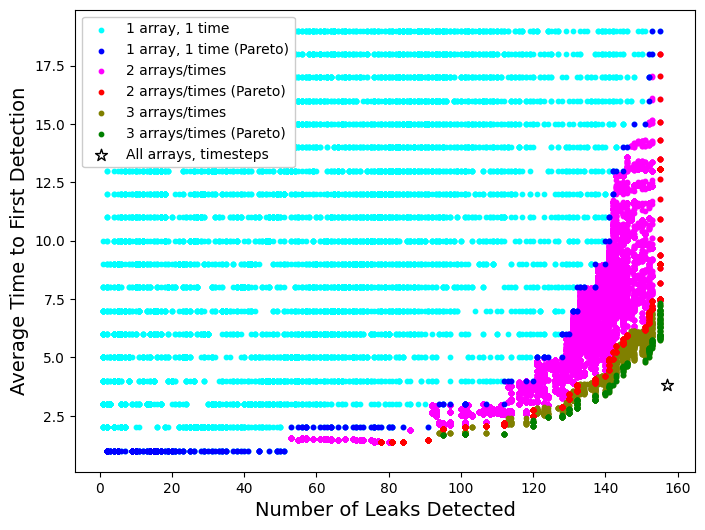

In [18]:
plans3 = additional_array_timings(plans2up,nrmsBool)
plans3up = find_unique_pareto(plans3)

x3 = np.array([plan[1] for plan in plans3])
y3 = np.array([plan[2] for plan in plans3])
r3 = pareto(x3,y3)

plt.figure(figsize=(8,6))
plt.scatter(x1,y1,s=10,c='cyan',label='1 array, 1 time')
plt.scatter(x1[r1==1],y1[r1==1],s=10,c='blue',zorder=4,label='1 array, 1 time (Pareto)')
plt.scatter(x2,y2,s=10,c='magenta',zorder=1,label='2 arrays/times')
plt.scatter(x2[r2==1],y2[r2==1],s=10,c='red',zorder=2,label='2 arrays/times (Pareto)')
plt.scatter(x3,y3,s=10,c='olive',zorder=1,label='3 arrays/times')
plt.scatter(x3[r3==1],y3[r3==1],s=10,c='green',zorder=2,label='3 arrays/times (Pareto)')
plt.scatter(det_best,np.mean(ttd_best),s=80,marker='*',ec='black',fc='white',zorder=5,label='All arrays, timesteps')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Number of Leaks Detected',fontsize=14)
plt.ylabel('Average Time to First Detection',fontsize=14)
plt.legend(loc='upper left', framealpha=1.0)
plt.show()

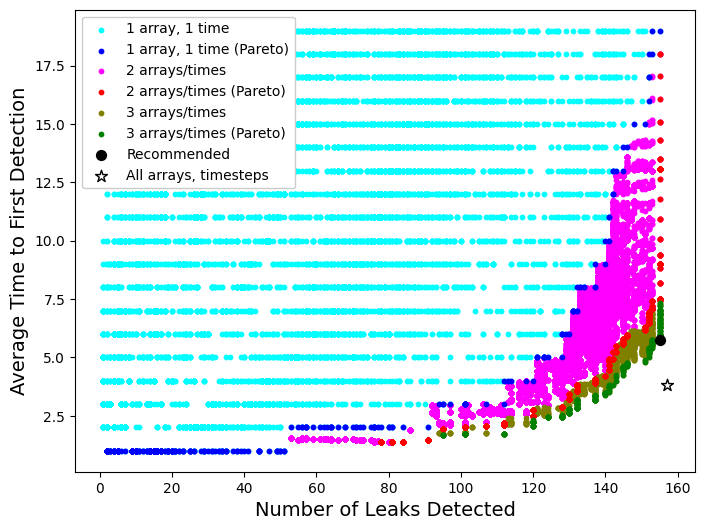

In [42]:
maxDet = np.where(x3==np.max(x3))[0]
ii=np.argsort(y3[maxDet])
iLowestTTDwmaxDet = maxDet[ii][0]

plt.figure(figsize=(8,6))
plt.scatter(x1,y1,s=10,c='cyan',label='1 array, 1 time')
plt.scatter(x1[r1==1],y1[r1==1],s=10,c='blue',zorder=4,label='1 array, 1 time (Pareto)')
plt.scatter(x2,y2,s=10,c='magenta',zorder=1,label='2 arrays/times')
plt.scatter(x2[r2==1],y2[r2==1],s=10,c='red',zorder=2,label='2 arrays/times (Pareto)')
plt.scatter(x3,y3,s=10,c='olive',zorder=1,label='3 arrays/times')
plt.scatter(x3[r3==1],y3[r3==1],s=10,c='green',zorder=2,label='3 arrays/times (Pareto)')

plt.scatter(x3[iLowestTTDwmaxDet],y3[iLowestTTDwmaxDet],s=50,c='black',zorder=9,label='Recommended')

plt.scatter(det_best,np.mean(ttd_best),s=80,marker='*',ec='black',fc='white',zorder=5,label='All arrays, timesteps')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Number of Leaks Detected',fontsize=14)
plt.ylabel('Average Time to First Detection',fontsize=14)
plt.legend(loc='upper left', framealpha=1.0)
plt.show()

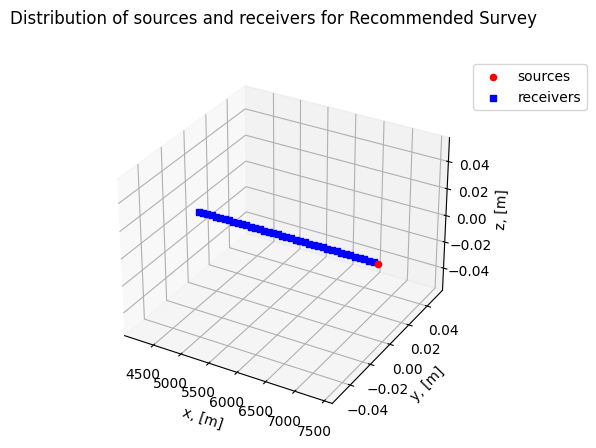

In [93]:
recommendedPlan = list(plans3)[iLowestTTDwmaxDet][0]
#recommendedPlan



num_sources = 9
sources = np.c_[4000 + np.array([240, 680, 1120, 1600, 2040, 2480, 2920, 3400, 3840]),
                np.zeros(num_sources),
                np.zeros(num_sources)]
sources = np.reshape(sources[produced_arrays[recommendedPlan[0][0]]['source']],[1,3])

num_receivers = 101
receivers = np.c_[4000 + np.linspace(0, 4000, num=num_receivers),
                  np.zeros(num_receivers),
                  np.zeros(num_receivers)]
receivers = receivers[produced_arrays[recommendedPlan[0][0]]['receivers']]

survey_config = SeismicSurveyConfiguration( sources, receivers, name='Recommended Survey')
survey_config.plot_configuration()